# Computations
This notebook is to review and compare computation performance for each scenario

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# take the long one to get a baseline
LONG = r'output_logs/211026104226'
SHORT120 = r'output_logs/211027170646'
SHORT180 = r'output_logs/211027145449'
SHORT240 = r'output_logs/211027070856'

comp_log_folders = [LONG,SHORT120,SHORT180,SHORT240]
comp_logs = dict()
comp_labels = ['long','120','180','240']
for lbl,folder in zip(comp_labels,comp_log_folders):
    
    print(lbl)
    comp_logs[lbl] = pd.read_csv(os.path.join(folder,'computation_log.csv'))
    

long
120
180
240


In [8]:
# gather all of the times in the dfs
time_cols = [col for col in comp_logs['240'] if "time" in col]
time_cols

['state_update_time',
 'rv_compute_time',
 'rtv_compute_time',
 'greedy_time',
 'data_gen_time',
 'main_ilp_time',
 'booking_time',
 'bal_ilp_time',
 'rebalance_booking_time']

In [13]:
time_data = pd.concat([comp_logs[lbl].loc[:,['t','MaxWait']+time_cols] 
                       for lbl in ['120','180','240']],ignore_index=True)
time_data.head()

,t,MaxWait,state_update_time,rv_compute_time,rtv_compute_time,greedy_time,data_gen_time,main_ilp_time,booking_time,bal_ilp_time,rebalance_booking_time
0,500430,120,0.008797,3.340611,3.190980,0.545645,0.032055,0.387989,1.530844,0.041236,0.001125
1,500460,120,0.831762,3.552119,1.058552,0.114277,0.013356,0.122298,0.519778,0.039307,0.001070
2,500490,120,1.052449,3.980385,3.080862,0.399164,0.028336,0.326390,1.777020,0.078334,0.003723
3,500520,120,1.806976,3.781132,1.337375,0.129472,0.013460,0.164488,0.739237,0.076786,0.005805
4,500550,120,2.049082,4.920053,4.128476,0.822659,0.029698,0.349951,1.734094,0.063961,0.006646


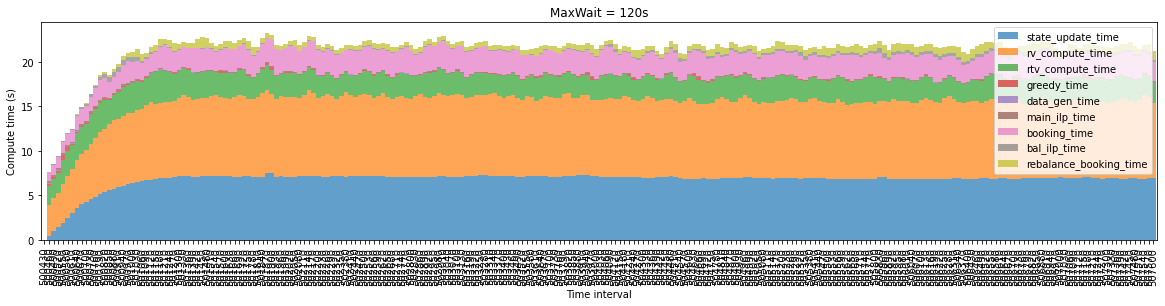

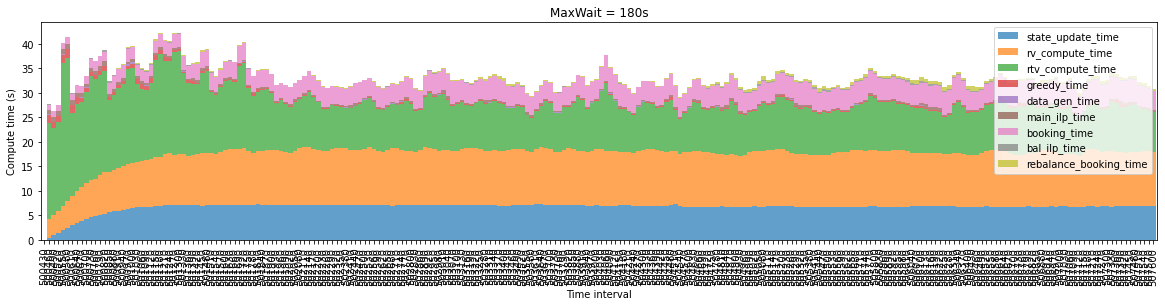

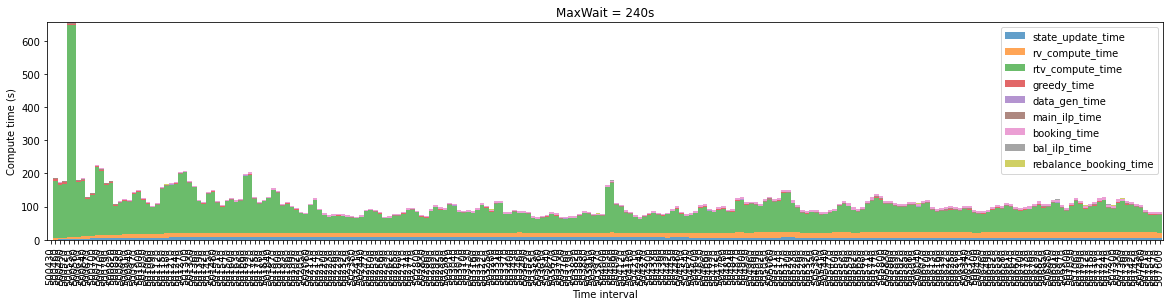

In [43]:
for MW,data in time_data.groupby(['MaxWait']):
    
    fig,ax = plt.subplots(figsize=(20,4))
    data.set_index(['t']).\
        rolling(2).mean().\
        loc[:,time_cols].\
        plot(kind='bar',stacked=True,ax=ax,width=1,alpha=0.7)
            
    ax.set_title(f"MaxWait = {MW}s")
    ax.set_xlabel("Time interval")
    ax.set_ylabel("Compute time (s)")
    plt.legend(loc='upper right')
                          
                          

Why is the ILP so fast?


In [37]:
# plot the number of constraints and variables over time
ilp_cols = [col for col in comp_logs['240'] if "ilp" in col]



['num_main_ilp_vars',
 'num_main_ilp_constr',
 'main_ilp_time',
 'num_bal_ilp_vars',
 'num_bal_ilp_constr',
 'bal_ilp_time']

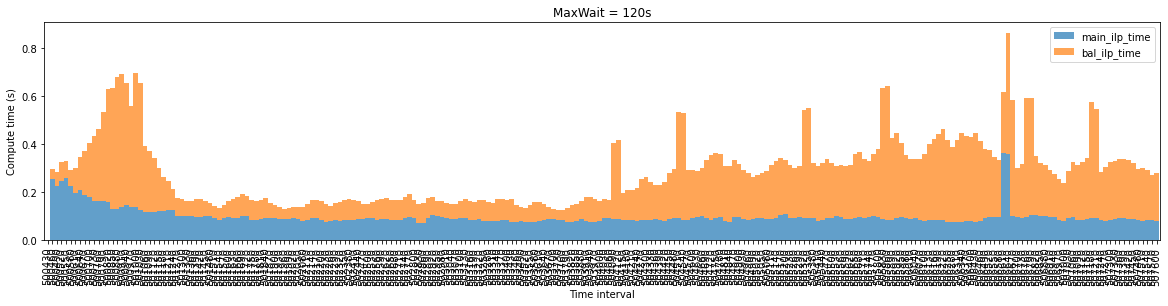

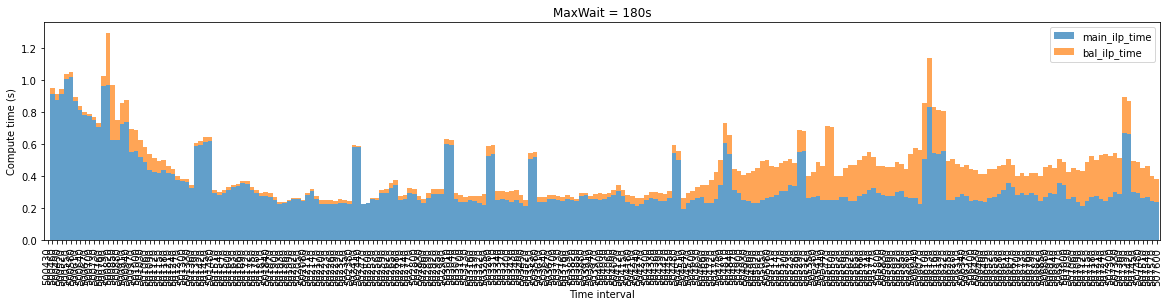

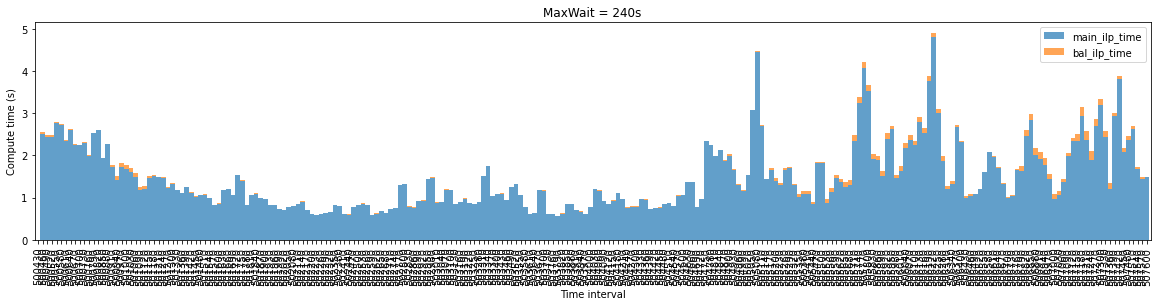

In [44]:
# just the ILP times
for MW,data in time_data.groupby(['MaxWait']):
    
    fig,ax = plt.subplots(figsize=(20,4))
    data.set_index(['t']).\
        rolling(2).mean().\
        loc[:,['main_ilp_time','bal_ilp_time']].\
        plot(kind='bar',stacked=True,ax=ax,width=1,alpha=0.7)
            
    ax.set_title(f"MaxWait = {MW}s")
    ax.set_xlabel("Time interval")
    ax.set_ylabel("Compute time (s)")
    
    plt.legend(loc='upper right')

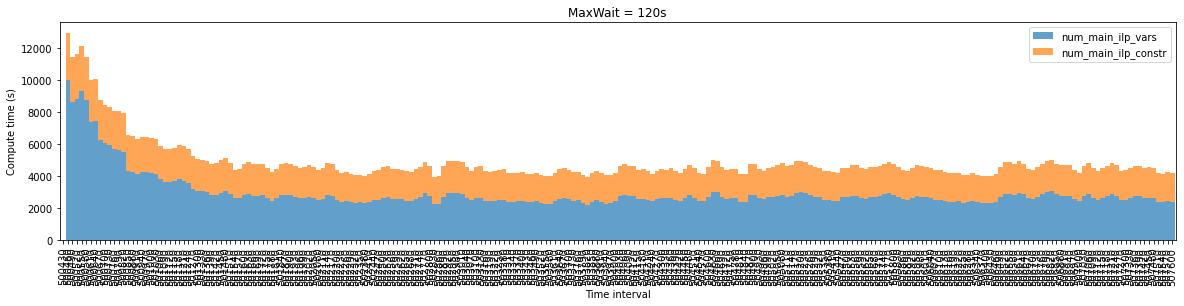

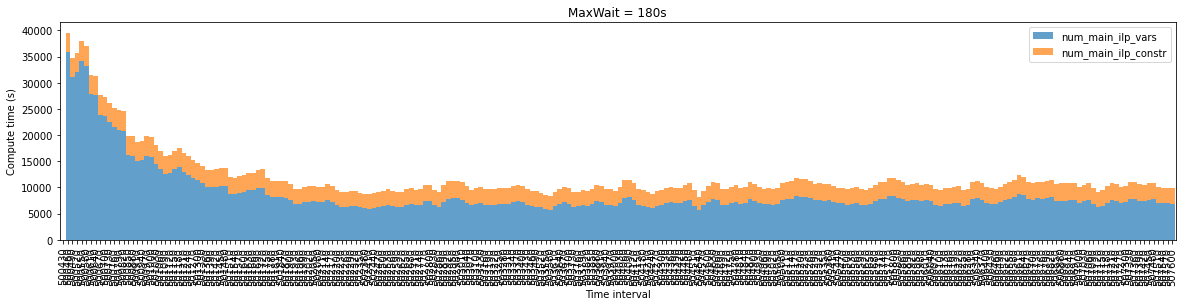

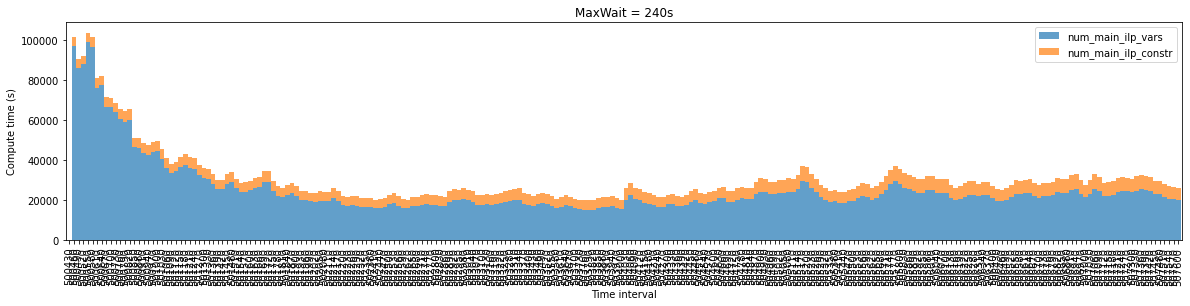

In [46]:
# plot the number of variables and constraints
# just the ILP times
for MW,data in time_data.groupby(['MaxWait']):
    
    fig,ax = plt.subplots(figsize=(20,4))
    data = comp_logs[str(MW)]
    data.set_index(['t']).\
        rolling(2).mean().\
        loc[:,['num_main_ilp_vars','num_main_ilp_constr']].\
        plot(kind='bar',stacked=True,ax=ax,width=1,alpha=0.7)
            
    ax.set_title(f"MaxWait = {MW}s")
    ax.set_xlabel("Time interval")
    ax.set_ylabel("Compute time (s)")
    
    plt.legend(loc='upper right')

Number of variables decrease once cabs are utilised. Show this. Show utilisation by time interval for each scenario.
